In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df=pd.read_csv('montwise_data.csv')

In [ ]:
df.columns = df.columns.str.strip()

df['Month'] = pd.to_datetime(df['Month'], errors='coerce')

df = df.dropna(subset=['Month'])

df.set_index('Month', inplace=True)

df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

df.head()

<ipython-input-4-39435ea9cf65>:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Month'] = pd.to_datetime(df['Month'], errors='coerce')


,Sales
Month,
2024-08-31,581024
2024-09-30,1508527
2024-10-31,5920192
2024-11-30,3833693
2024-12-31,2580489


Converting Month into datetime

In [ ]:
df.describe()

,Sales
count,7.000000e+00
mean,2.867147e+06
std,1.704772e+06
min,5.810240e+05
25%,2.044508e+06
50%,2.713683e+06
75%,3.383056e+06
max,5.920192e+06


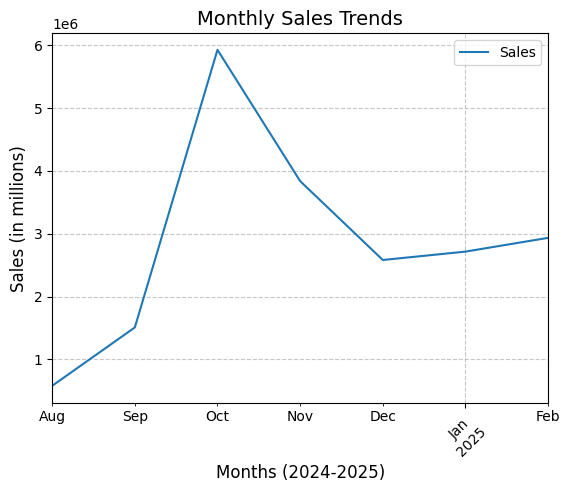

In [ ]:
df.plot()

plt.title("Monthly Sales Trends", fontsize=14)
plt.xlabel("Months (2024-2025)", fontsize=12)
plt.ylabel("Sales (in millions)", fontsize=12)


plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


In [ ]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result=adfuller(df['Sales'])

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary (p-value < 0.05)")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary (p-value > 0.05) ")


In [ ]:
adfuller_test(df['Sales'])

ADF Test Statistic : -4.509276658624644
p-value : 0.00018918809736319053
#Lags Used : 1
Number of Observations Used : 5
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary (p-value < 0.05)


# if the data is non stationary we apply differencing, in our case data points are stationary

ACF,PACF

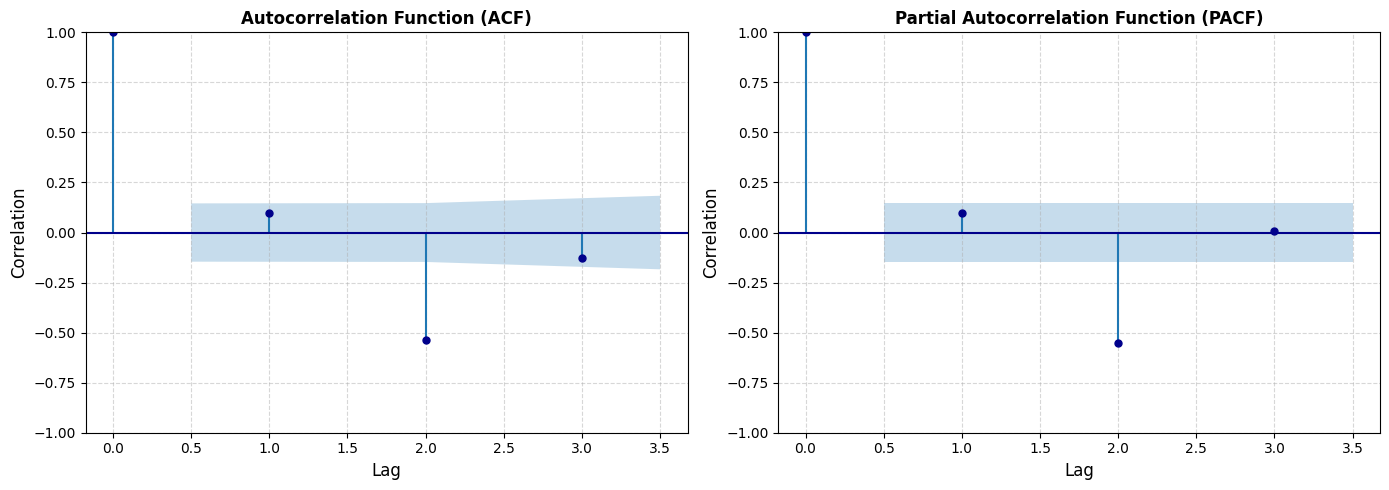

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Plot ACF & PACF with improvements
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(df['Sales'], ax=axes[0], color='darkblue', alpha=0.7)
axes[0].set_title("Autocorrelation Function (ACF)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Lag", fontsize=12)
axes[0].set_ylabel("Correlation", fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# PACF plot
plot_pacf(df['Sales'], ax=axes[1], color='darkblue', alpha=0.7)
axes[1].set_title("Partial Autocorrelation Function (PACF)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Lag", fontsize=12)
axes[1].set_ylabel("Correlation", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
# Fit ARIMA(1,0,1) model (since data is stationary, d=0)
arima_model = ARIMA(df['Sales'], order=(1, 0, 1))
arima_result = arima_model.fit()

# Display ARIMA model summary
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                    7
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -109.836
Date:                Thu, 03 Apr 2025   AIC                            227.672
Time:                        15:59:24   BIC                            227.456
Sample:                    08-31-2024   HQIC                           224.998
                         - 02-28-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.876e+06   6.74e+05      4.263      0.000    1.55e+06     4.2e+06
ar.L1         -1.0000      1.162     -0.860      0.390      -3.278       1.278
ma.L1          1.0000      0.974      1.027      0.3

<ipython-input-14-012573a464eb>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:]


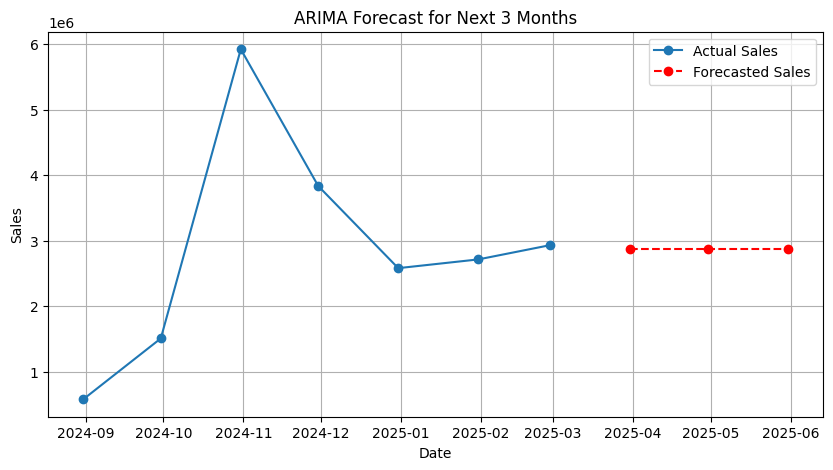

In [ ]:
# Forecast the next 3 months
forecast_steps = 3
forecast = arima_result.forecast(steps=forecast_steps)

# Generate future dates
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:]

# Plot actual vs forecasted sales
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Sales'], label="Actual Sales", marker='o', linestyle='-')
plt.plot(forecast_dates, forecast, label="Forecasted Sales", marker='o', linestyle='dashed', color='red')

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("ARIMA Forecast for Next 3 Months")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Fit SARIMA model (p, d, q) × (P, D, Q, s)
sarima_model = SARIMAX(df['Sales'],
                       order=(1, 0, 1),      # ARIMA(p, d, q)
                       seasonal_order=(1, 0, 1, 12),  # (P, D, Q, seasonality period)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Display model summary
print(sarima_result.summary())



                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                    7
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                   0.000
Date:                            Thu, 03 Apr 2025   AIC                             10.000
Time:                                    15:59:31   BIC                                nan
Sample:                                08-31-2024   HQIC                               nan
                                     - 02-28-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8004         -0       -inf      0.000       0.800       0.800
ma.L1         -0.1566         -0   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.11/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/usr

<ipython-input-17-b55496b0e187>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('M')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
<ipython-input-17-b55496b0e187>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


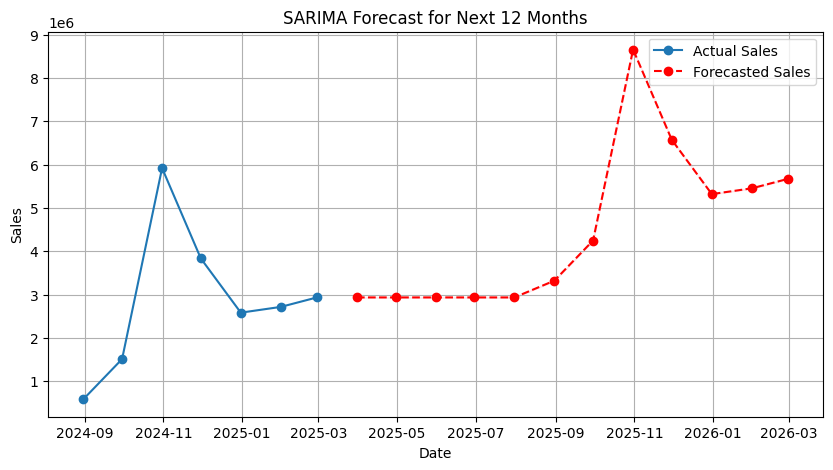

In [ ]:
# Ensure the index is a DateTimeIndex with a monthly frequency
df = df.asfreq('M')

# Fit the SARIMA model
sarima_model = SARIMAX(df['Sales'],
                       order=(1, 1, 1),        # ARIMA(p, d, q)
                       seasonal_order=(1, 1, 1, 12),  # (P, D, Q, seasonality)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Forecast for 12 months
forecast_steps = 12
forecast = sarima_result.get_forecast(steps=forecast_steps)

# Get confidence intervals
conf_int = forecast.conf_int()

# Generate future dates
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Plot actual vs forecasted sales
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Sales'], label="Actual Sales", marker='o', linestyle='-')
plt.plot(forecast_dates, forecast.predicted_mean, label="Forecasted Sales", marker='o', linestyle='dashed', color='red')

# Confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("SARIMA Forecast for Next 12 Months")
plt.legend()
plt.grid()
plt.show()
